# Environmental Corruption Tutorial

In realistic speech processing applications, the signal recorded by the microphone is corrupted by **noise** and **reverberation**. This is particularly harmful in **distant-talking** (far-field) scenarios, where the speaker and the reference microphone are distant (think about popular devices such as Google Home, Amazon Echo, Kinect, and similar devices).

A common practice in neural speech processing is to start from clean speech recordings and artificially turn them into noisy ones. This process is called **environmental corruption** (sometimes also referred to as *speech contamination*). 

The advantage of starting from a clean signal is that we can artificially contaminate it in many different ways (just using different sequences of noise and reverberation). Environmental corruption is thus a powerful regularization technique that helps the network generalize better on the test set.

The environmental corruption transforms an clean signal $x[n]$ into a noisy and reverberant signal in this way:

$y[n] = x[n] * h[n] + n[n]$

where $n[n]$ is a noise sequence, and $h[n]$ is an impulse response (that adds the reverberation effect).

In the following sections, we will explain how we can do this transformation. Before that, let's download some signals that will be useful for the rest of the tutorial:


In [1]:
%%capture
!pip install speechbrain
!wget https://www.dropbox.com/s/vwv8xdr7l3b2tta/noise_sig.csv
!wget https://www.dropbox.com/s/aleer424jumcs08/noise2.wav
!wget https://www.dropbox.com/s/eoxxi2ezr8owk8a/noise3.wav
!wget https://www.dropbox.com/s/pjnub2s5hql2vxs/rir1.wav
!wget https://www.dropbox.com/s/nyno6bqbmiy2rv8/rirs.csv
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

A clean speech signal looks like this:

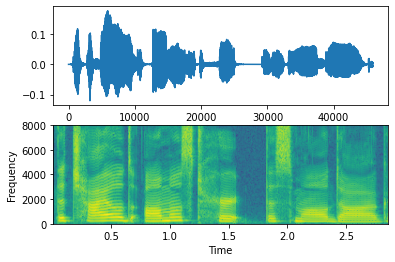

In [2]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio

clean = read_audio('spk1_snt1.wav').squeeze()

# Plots
plt.subplot(211)
plt.plot(clean)
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(clean,Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(clean, rate=16000)

matplotlib.pyplot.specgram() 메서드를 사용하여 A = 20sin(3 *np.pi *t)함수에 대한 스펙트로 그램을 생성 합니다. (fs = 샘플링 빈도)  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html

## 1. Additive Noise

In SpeechBrain, we designed a class able to contaminate a speech signal with noise (`speechbrain.processing.speech_augmentation.AddNoise`). This class takes in input a csv file that itemizes a list of noise signals:


```
ID, duration, wav, wav_format, wav_opts
noise2, 5.0, noise2.wav, wav,
noise3, 1.0, noise3.wav, wav,
```
When called, `AddNoise` samples from this noise collection and adds the selected noise into the clean signal with a random **Signal-to-Nose Ratio** (SNR).



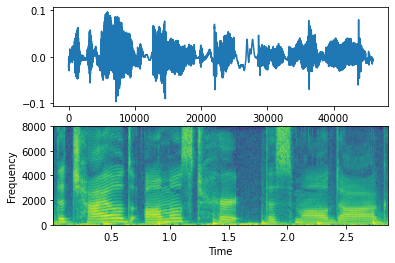

In [3]:
import torch
from speechbrain.processing.speech_augmentation import AddNoise
noisifier = AddNoise('noise_sig.csv', snr_low=0, snr_high=5)
lengths = torch.ones(1)
noisy = noisifier(clean.unsqueeze(0), lengths)

# Plots
plt.subplot(211)
plt.plot(noisy.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(noisy.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noisy.squeeze(0), rate=16000)


The amount of noise can be tuned with the **snr_low** and **snr_high** parameters that define the sampling range for the SNR. The length vector is needed because we can process in parallel batches of signals with different lengths. The length vector contains relative lengths for each sentence composing the batch (e.g, for two examples we can have lenght=[0.8 1.0] where 1.0 is the length of the longest sentence in the batch).


## 2. Reverberation
When speaking into a room, our speech signal is **reflected multi-times** by the walls, floor, ceiling, and by the objects within the acoustic environment. Consequently, the final signal recorded by a distant microphone will contain multiple **delayed replicas** of the original signal. All these replicas interfere with each other and significantly affect the intelligibility of the speech signal.

Such a **multi-path propagation** is called reverberation. Within a given room enclosure, the reverberation between a source and a receiver is modeled by an **impulse response**: 


Text(0, 0.5, 'h(t)')

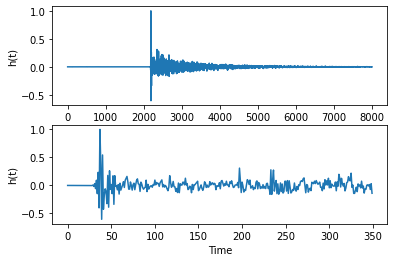

In [4]:
rir = read_audio('rir1.wav')

# Impulse response
plt.subplot(211)
plt.plot(rir[0:8000])
plt.xlabel('Time')
plt.ylabel('h(t)')

# Zoom on early reflections
plt.subplot(212)
plt.plot(rir[2150:2500])
plt.xlabel('Time')
plt.ylabel('h(t)')

The impulse response is a complete description of the changes that the sounds undergo when traveling from a source to a receiver. In particular, each peak in the impulse response corresponds to a replica reaching the receiver. The first peak corresponds to the **direct path**. Then, we can see the **first-order reflections** on walls, ceiling, floor (see the second picture). 

Globally, the impulse response follows an exponential decay. This decay is faster in a dry room characterized by low reverberation-time and it is slower in a large and empty environment. 

The reverberation is added by performing a **convolution** between a clean signal and an impulse response. In SpeechBrain, this operation is performed by `speechbrain.processing.speech_augmentation.AddReverb`.

When called, `AddRev` samples an impulse response from a given csv file:

```
ID, duration, wav, wav_format, wav_opts
rir1, 1.0, rir1.wav, wav,
....
```

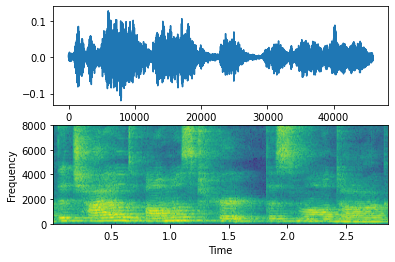

In [5]:
from speechbrain.processing.speech_augmentation import AddReverb
reverb = AddReverb('rirs.csv', rir_scale_factor=1.0)
reverbed = reverb(clean, torch.ones(1))

# Plots
plt.subplot(211)
plt.plot(reverbed.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(reverbed.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(reverbed.squeeze(0), rate=16000)


Reverberation is a convolutive noise that "smooths" the signal in the time (see the long tails that appear in regions that were silent in the clean signal) and frequency domain.

The amount of reverberation is controlled by the parameter **rir_scale_factor**. If rir_scale_factor < 1, the impulse response is compressed (less reverb), while if rir_scale_factor > 1 the impulse response is dilated (more reverb). Feel free to play with it in the previous example!

## Environmental Corruption Lobe

Noise and reverberation are often combined and activated with a certain probability. To make this easier, in SpeechBrain we have a class called TimeDomainSpecAugment in speechbrain.lobes.augment.EnvCorrupt.

Within this class, the corruption operations are performed in the right order. For instance, we first introduce reverberation, and only later noise is added.
This class automatically downloads an open-source dataset of impulse responses and noise sequences called [open-rir](http://www.openslr.org/resources/28/) and performs environmental corruption sampling from it.


rirs_noises.zip: 1.31GB [00:39, 33.0MB/s]                            


Extracting ./rirs_noises.zip to .


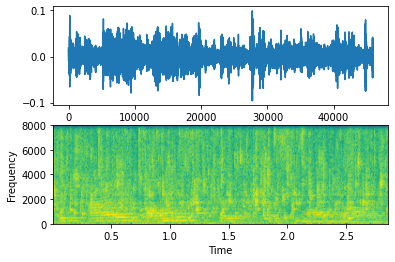

In [6]:
from speechbrain.lobes.augment import EnvCorrupt

# Downloading and upacking open rir might take several minutes
corrupter = EnvCorrupt(openrir_folder='.') 
noise_rev = corrupter(clean.unsqueeze(0), torch.ones(1))

# Plots
plt.subplot(211)
plt.plot(noise_rev.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(noise_rev.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noise_rev.squeeze(0), rate=16000)




If we call the function another time, the signal is contaminated in a different way. This allows us to implement an on-the-fly speech contamination and apply different distortions to each different input.

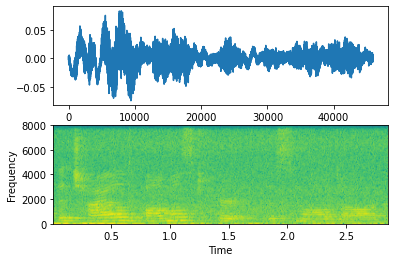

In [7]:
noise_rev = corrupter(clean.unsqueeze(0), torch.ones(1))

# Plots
plt.subplot(211)
plt.plot(noise_rev.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.specgram(noise_rev.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(noise_rev.squeeze(0), rate=16000)

Environmental corruption is not computationally demanding and does not slow down the training loop even when doing it on-the-fly.

There are other types of distortions that can be used to perform speech augmentation (e.g, speed change, time dropout, frequency dropout, clipping). All these techniques are described in the [speech augmentation tutorial](https://colab.research.google.com/drive/16mUGH_A3UHZZOx2Vn69hy6fkPAM8CnA4?usp=sharing).

## References
[1] M. Ravanelli, P. Svaizer, M. Omologo, "Realistic Multi-Microphone Data Simulation for Distant Speech Recognition",  in Proceedings of Interspeech 2016 [ArXiv](https://arxiv.org/abs/1711.09470)

[2] M. Ravanelli, M. Omologo, "Contaminated speech training methods for robust DNN-HMM distant speech recognition", in Proceedings of  INTERSPEECH 2015. [ArXiv](https://arxiv.org/abs/1710.03538)

[3] M. Ravanelli, M. Omologo, "On the selection of the impulse responses for distant-speech recognition based on contaminated speech training", in Proceedings of  INTERSPEECH 2014. [ArXiv](https://isca-speech.org/archive/archive_papers/interspeech_2014/i14_1028.pdf)

[4] M. Ravanelli, A. Sosi, P. Svaizer, M.Omologo, "Impulse response estimation for robust speech recognition in a reverberant environment",   in Proceeding of the European Signal Processing Conference, EUSIPCO 2012. [ArXiv](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2012/Conference/papers/1569588145.pdf)



# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```